/tmp/ipykernel_1351/4056651921.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("history.csv", names=["entity_id", "value", "timestamp"], parse_dates=["timestamp"])


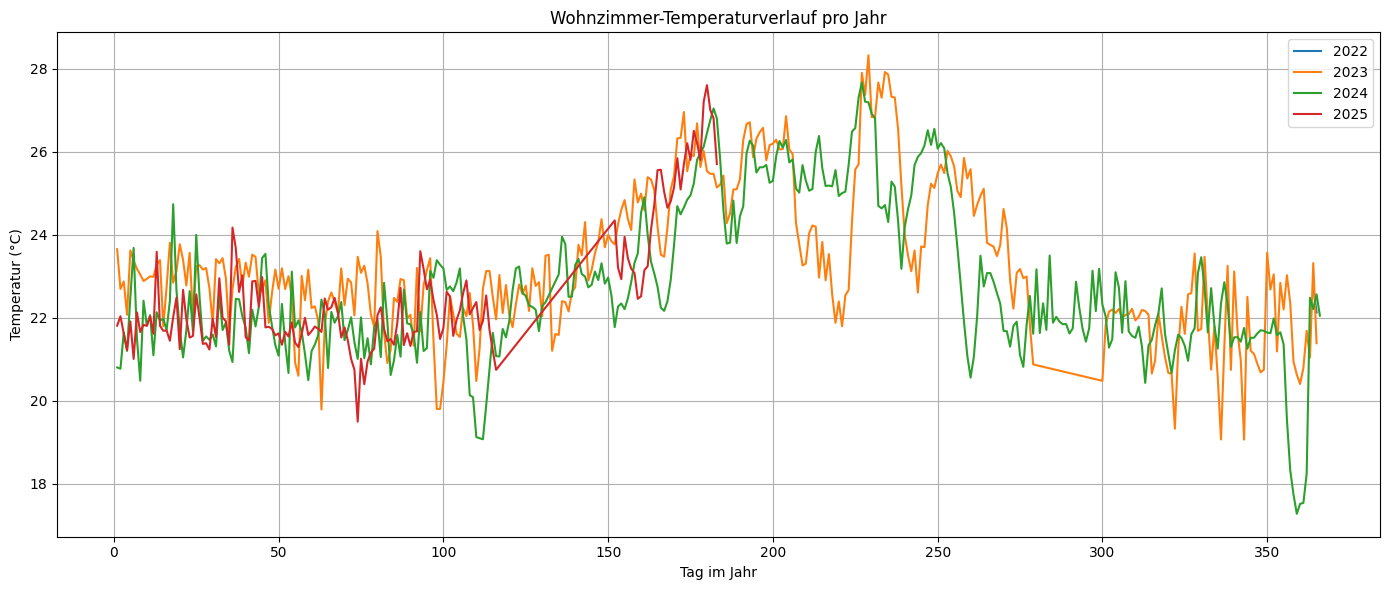

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV laden
df = pd.read_csv("history.csv", names=["entity_id", "value", "timestamp"], parse_dates=["timestamp"])

df["value"] = pd.to_numeric(df["value"], errors="coerce")
df.dropna(subset=["value", "timestamp"], inplace=True)

df = df[(df["value"] > 5) & (df["value"] < 35)]
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

df["year"] = df["timestamp"].dt.year
df["dayofyear"] = df["timestamp"].dt.dayofyear
df["month_day"] = df["timestamp"].dt.strftime("%m-%d")
df["month_name"] = df["timestamp"].dt.strftime("%b")  # Jan, Feb, ...


daily = df.groupby(["year", "dayofyear"])["value"].max().reset_index()

# Plot erstellen
plt.figure(figsize=(14, 6))
for year in sorted(daily["year"].unique()):
    ydata = daily[daily["year"] == year]
    plt.plot(ydata["dayofyear"], ydata["value"], label=str(year))

plt.title("Wohnzimmer-Temperaturverlauf pro Jahr")
plt.xlabel("Tag im Jahr")
plt.ylabel("Temperatur (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("wohnzimmer_temperaturverlauf.png", dpi=300, bbox_inches="tight")

plt.show()


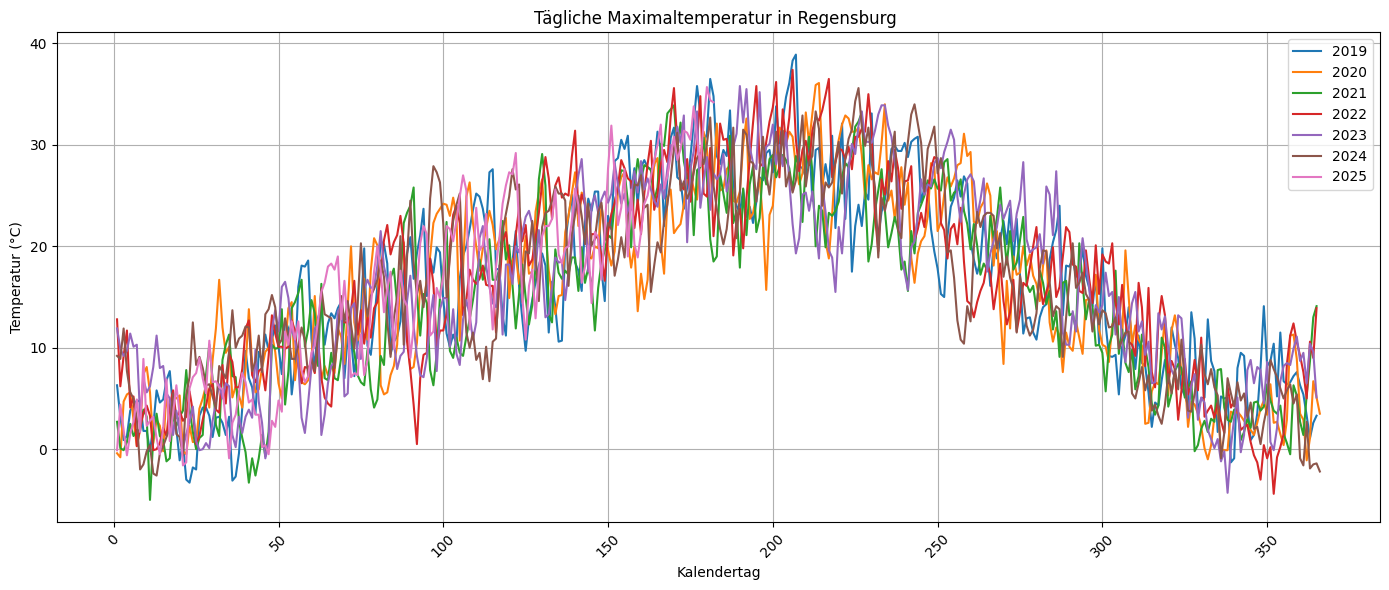

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
columns = [
    "STATIONS_ID", "MESS_DATUM", "QN_3", "FX", "FM",
    "QN_4", "RSK", "RSKF", "SDK", "SHK_TAG",
    "NM", "VPM", "PM", "TMK", "UPM",
    "TXK", "TNK", "TGK", "eor"
]
# CSV laden

df_hist = pd.read_csv("produkt_klima_tag_18790101_20241231_04104.txt",
                      sep=";", skiprows=1, names=columns,
                      parse_dates=["MESS_DATUM"], na_values=["-999", "-999.0"])


#df_hist = df_hist[(df_hist["MESS_DATUM"].dt.year >= 2011) & (df_hist["MESS_DATUM"].dt.year <= 2025)]

df = pd.read_csv("produkt_klima_tag_20231230_20250701_04104.txt", names=columns,sep=";",skiprows=1, parse_dates=["MESS_DATUM"])

df_all = pd.concat([df_hist, df], ignore_index=True)
df_all = df_all.dropna(subset=["TXK"])  # nur Tage mit Max-Temp
#df_all = df_all[(df_all["MESS_DATUM"].dt.year >= 2019) & (df_all["MESS_DATUM"].dt.year <= 2025)]
df_all["year"] = df_all["MESS_DATUM"].dt.year
df_all["dayofyear"] = df_all["MESS_DATUM"].dt.dayofyear
df_all["month_day"] = df_all["MESS_DATUM"].dt.strftime("%m-%d")

df["MESS_DATUM"] = pd.to_datetime(df_all["MESS_DATUM"], format="%Y%m%d")
df = df_all[["MESS_DATUM", "TXK"]].dropna()
df = df[(df["MESS_DATUM"].dt.year >= 2019) & (df["MESS_DATUM"].dt.year <= 2025)]

df["year"] = df["MESS_DATUM"].dt.year
df["dayofyear"] = df["MESS_DATUM"].dt.dayofyear

daily = df.groupby(["year", "dayofyear"])["TXK"].max().reset_index()

# Plot
plt.figure(figsize=(14, 6))
for year in sorted(daily["year"].unique()):
    ydata = daily[daily["year"] == year]
    plt.plot(ydata["dayofyear"], ydata["TXK"], label=str(year))

plt.title("Tägliche Maximaltemperatur in Regensburg ")
plt.xlabel("Kalendertag")
plt.ylabel("Temperatur (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("regensburg_temperaturverlauf.png", dpi=300, bbox_inches="tight")

plt.show()


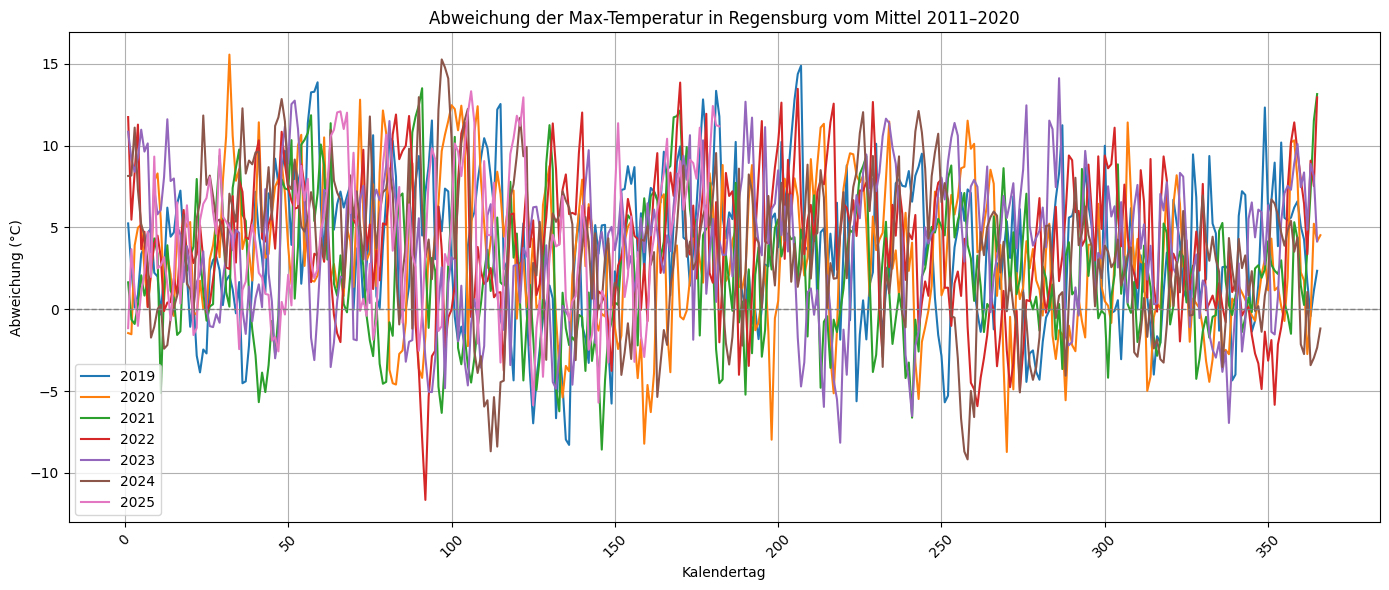

In [89]:
norm = df_all[df_all["year"] <= 1990].groupby("dayofyear")["TXK"].mean()

# Abweichung je Jahr berechnen
years = [2019, 2020, 2021, 2022,2023, 2024, 2025]
plt.figure(figsize=(14, 6))

for year in years:
    year_data = df_all[df_all["year"] == year].groupby("dayofyear")["TXK"].mean()
    diff = year_data - norm
    plt.plot(diff.index, diff.values, label=f"{year}")

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Abweichung der Max-Temperatur in Regensburg vom Mittel 2011–2020")
plt.ylabel("Abweichung (°C)")
plt.xlabel("Kalendertag")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("regensburg_abweichung_temperaturverlauf.png", dpi=300, bbox_inches="tight")
plt.show()

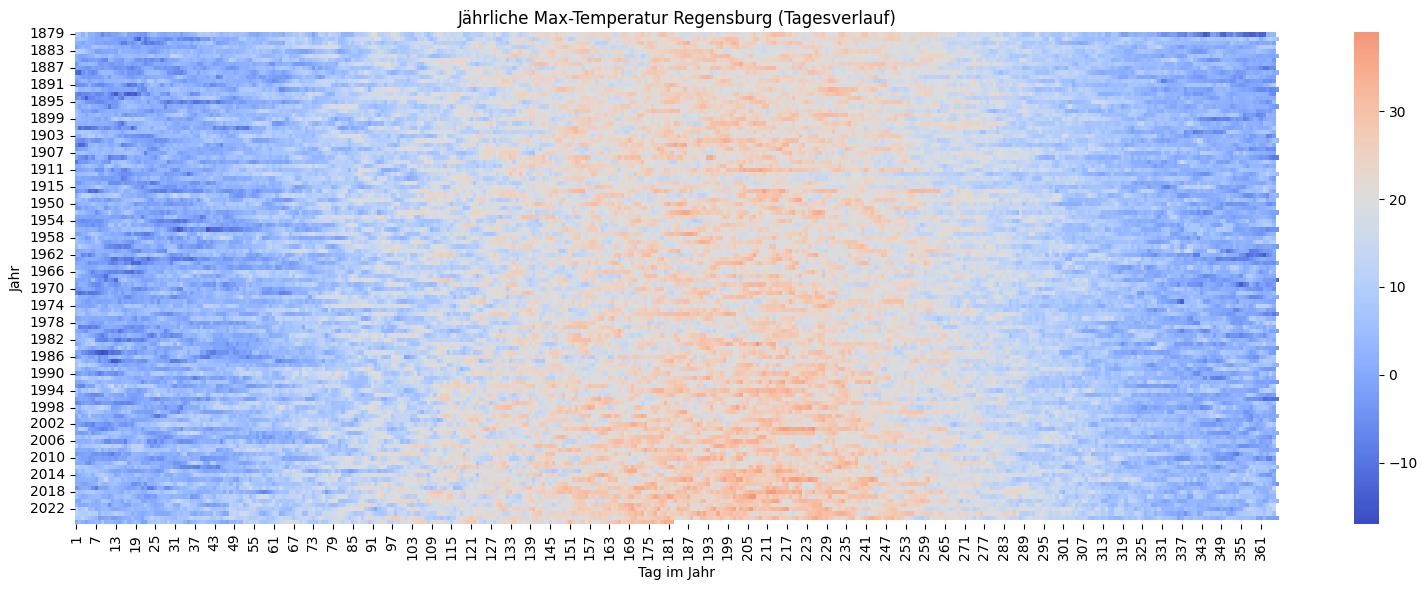

In [91]:
import seaborn as sns

# Matrix: Zeilen = Jahr, Spalten = Kalendertag, Werte = Temperatur
heatmap_df = df_all.pivot_table(index="year", columns="dayofyear", values="TXK")

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_df, cmap="coolwarm", center=20)
plt.title("Jährliche Max-Temperatur Regensburg (Tagesverlauf)")
plt.xlabel("Tag im Jahr")
plt.ylabel("Jahr")
plt.tight_layout()
plt.savefig("regensburg_heatmap.png", dpi=300, bbox_inches="tight")

plt.show()

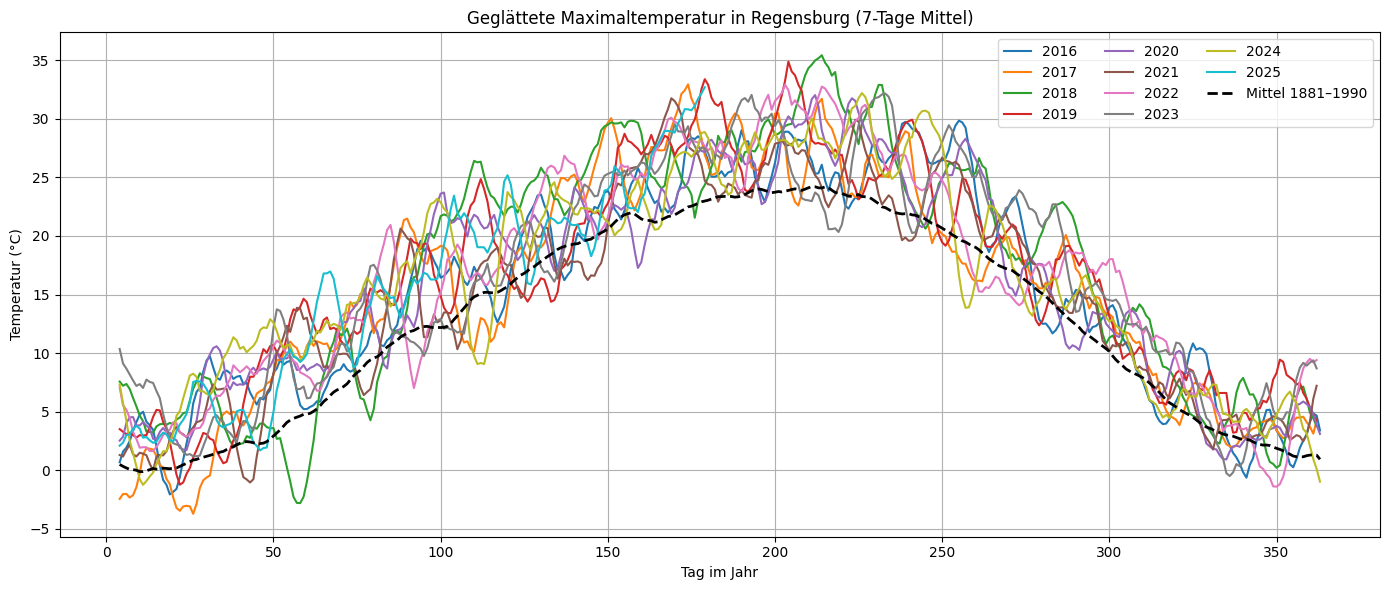

In [96]:

df_all["year"] = df_all["MESS_DATUM"].dt.year
df_all["dayofyear"] = df_all["MESS_DATUM"].dt.dayofyear
historic = df_all[(df_all["year"] >= 1881) & (df_all["year"] <= 1990)]
historic_mean = historic.groupby("dayofyear")["TXK"].mean().rolling(7, center=True).mean()
plt.figure(figsize=(14, 6))

# Jährliche Linien
for year in range(2016, 2026):
    ydata = df_all[df_all["year"] == year].groupby("dayofyear")["TXK"].mean().rolling(7, center=True).mean()
    plt.plot(ydata.index, ydata.values, label=str(year))

# Historischer Referenzwert
plt.plot(historic_mean.index, historic_mean.values, label="Mittel 1881–1990", color="black", linewidth=2, linestyle="--")

# Plot-Details
plt.title("Geglättete Maximaltemperatur in Regensburg (7-Tage Mittel)")
plt.xlabel("Tag im Jahr")
plt.ylabel("Temperatur (°C)")
plt.legend(ncol=3)
plt.grid(True)
plt.tight_layout()

plt.savefig("regensburg_filtered_temp.png", dpi=300, bbox_inches="tight")

plt.show()


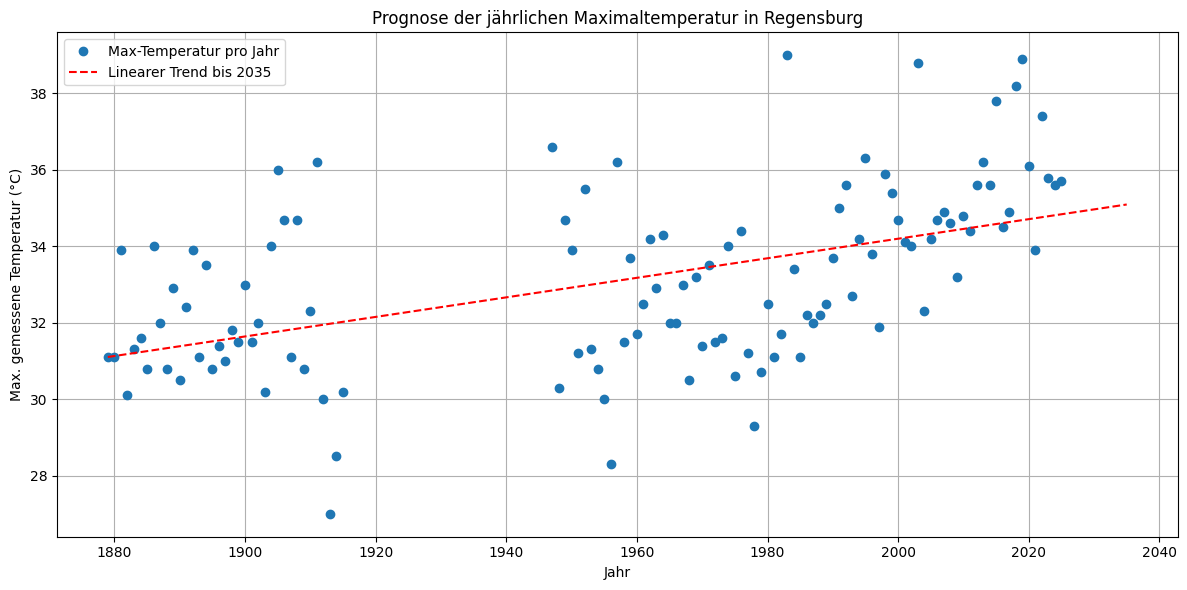

In [101]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Jahr und Max-Temperatur je Jahr
yearly_max = df_all.groupby("year")["TXK"].max().dropna()
X = yearly_max.index.values.reshape(-1, 1)  # Jahre
y = yearly_max.values                      # Max-Temp

# Regressionsmodell fitten
model = LinearRegression()
model.fit(X, y)

# Trendlinie
years_future = np.arange(X.min(), 2036).reshape(-1, 1)
trend = model.predict(years_future)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(yearly_max.index, yearly_max.values, "o", label="Max-Temperatur pro Jahr")
plt.plot(years_future, trend, "r--", label="Linearer Trend bis 2035")
plt.xlabel("Jahr")
plt.ylabel("Max. gemessene Temperatur (°C)")
plt.title("Prognose der jährlichen Maximaltemperatur in Regensburg")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Prognose_regensburg_Maximaltemperatur.png", dpi=300, bbox_inches="tight")

plt.show()


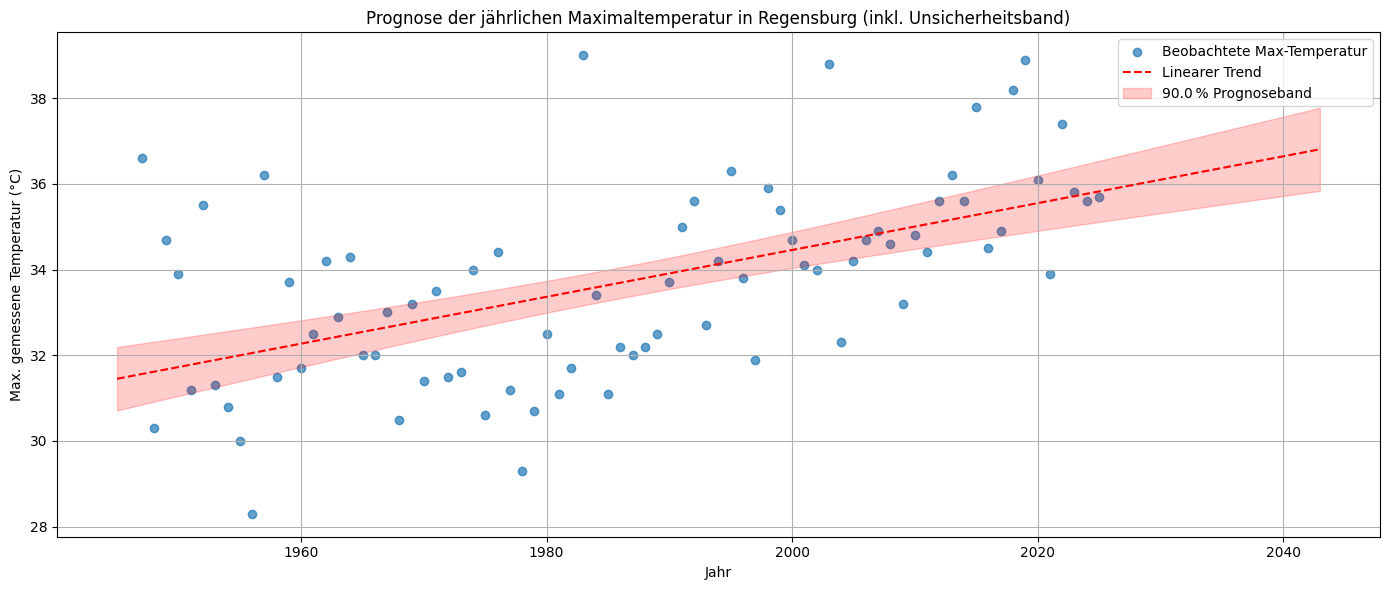

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import t

confidence = 0.99


# Daten: Max-Temperatur pro Jahr
yearly_max = df_all[df_all["year"] >= 1945].groupby("year")["TXK"].max().dropna()

X = yearly_max.index.values.reshape(-1, 1)
y = yearly_max.values
model = LinearRegression().fit(X, y)

# Prognosebereich
years_future = np.arange(1945, 2044)
X_future = years_future.reshape(-1, 1)
y_pred = model.predict(X_future)

# Regressionsdetails
n = len(X)
mean_x = X.mean()
alpha = 1 - confidence
t_val = t.ppf(1 - alpha / 2, df=n - 2)


# Residuen & Standardfehler
y_fit = model.predict(X)
residuals = y - y_fit
se = np.sqrt(np.sum(residuals**2) / (n - 2))

# Konfidenzintervall berechnen
se_fit = se * np.sqrt(
    1/n + (X_future.flatten() - mean_x)**2 / np.sum((X.flatten() - mean_x)**2)
)
conf_interval = t_val * se_fit
lower = y_pred - conf_interval
upper = y_pred + conf_interval
plt.figure(figsize=(14, 6))
plt.scatter(X, y, label="Beobachtete Max-Temperatur", alpha=0.7)
plt.plot(years_future, y_pred, "r--", label="Linearer Trend")
plt.fill_between(years_future, lower, upper, color="red", alpha=0.2, label=str(confidence*100) + " % Prognoseband")

plt.xlabel("Jahr")
plt.ylabel("Max. gemessene Temperatur (°C)")
plt.title("Prognose der jährlichen Maximaltemperatur in Regensburg (inkl. Unsicherheitsband)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Prognose_regensburg_Maximaltemperatur_mit_Unsicherheitsband.png", dpi=300, bbox_inches="tight")

plt.show()
